## Understand the Data Structure (EDA)

In [8]:
import pandas as pd

# Load the dataset
file_path = "paysim1/PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(file_path)

# Overview of the dataset
print(df.info())       # Data types and missing values
print(df.describe())   # Summary statistics
print(df.head())       # First few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04

## Transaction Volume & Distribution

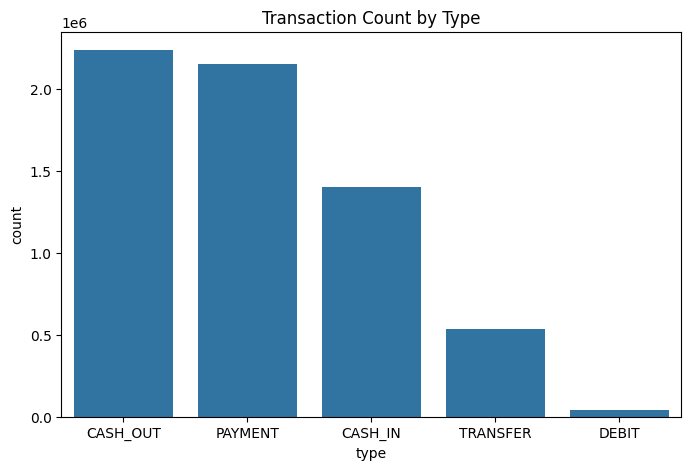

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transaction type counts
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="type", order=df["type"].value_counts().index)
plt.title("Transaction Count by Type")
plt.show()

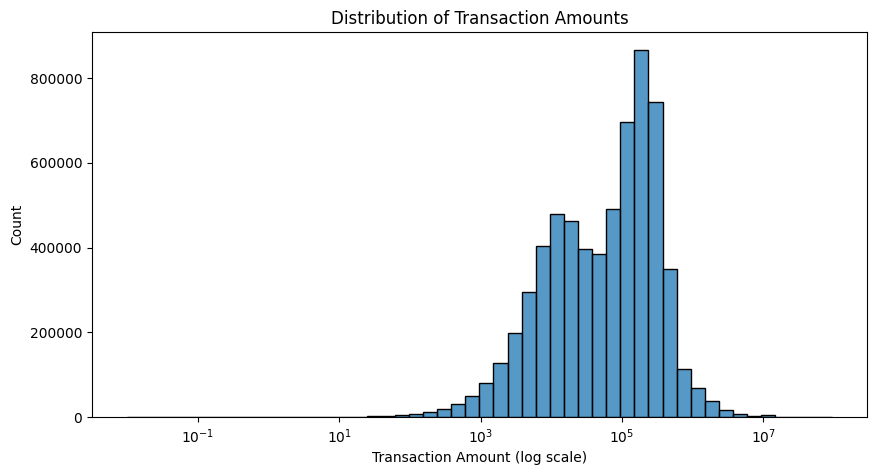

In [10]:
# Distribution of transaction amounts
plt.figure(figsize=(10,5))
sns.histplot(df["amount"], bins=50, log_scale=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount (log scale)")
plt.show()

## Fraud Detection Analysis

In [11]:
# Count fraud cases per transaction type
fraud_counts = df[df["isFraud"] == 1]["type"].value_counts()
print(fraud_counts)

# Percentage of fraudulent transactions by type
fraud_percentage = (df.groupby("type")["isFraud"].mean() * 100).round(2)
print(fraud_percentage)


type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64
type
CASH_IN     0.00
CASH_OUT    0.18
DEBIT       0.00
PAYMENT     0.00
TRANSFER    0.77
Name: isFraud, dtype: float64


## Log Transformation

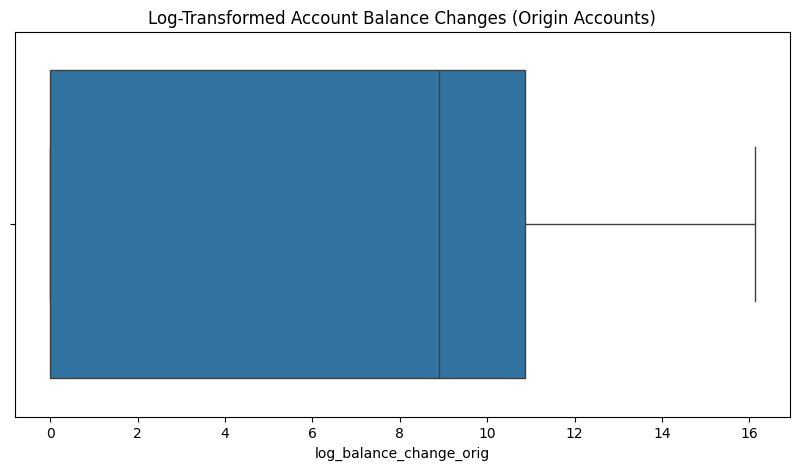

In [14]:
import numpy as np

# Avoid log(0) and negative values by adding a small constant
df["log_balance_change_orig"] = np.log1p(df["balance_change_orig"].abs())

plt.figure(figsize=(10, 5))
sns.boxplot(x=df["log_balance_change_orig"])
plt.title("Log-Transformed Account Balance Changes (Origin Accounts)")
plt.show()

## Filter Out Extreme Outliers

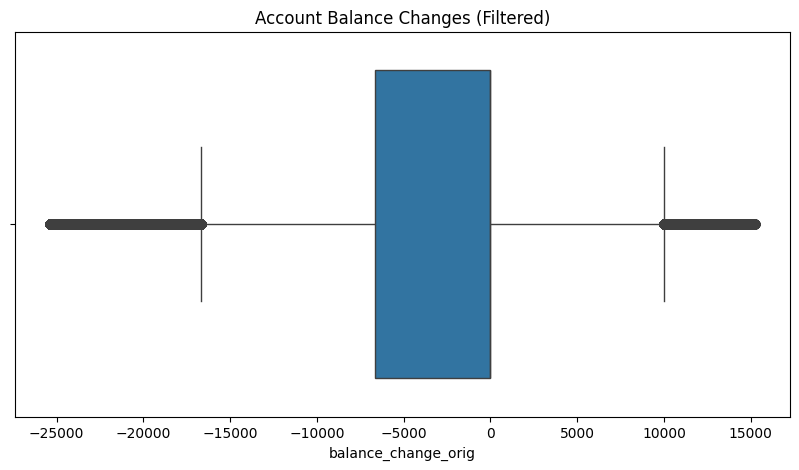

In [15]:
# Calculate IQR
Q1 = df["balance_change_orig"].quantile(0.25)
Q3 = df["balance_change_orig"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier limits
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out extreme values
df_filtered = df[(df["balance_change_orig"] >= lower_bound) & (df["balance_change_orig"] <= upper_bound)]

# Boxplot without extreme outliers
plt.figure(figsize=(10,5))
sns.boxplot(x=df_filtered["balance_change_orig"])
plt.title("Account Balance Changes (Filtered)")
plt.show()

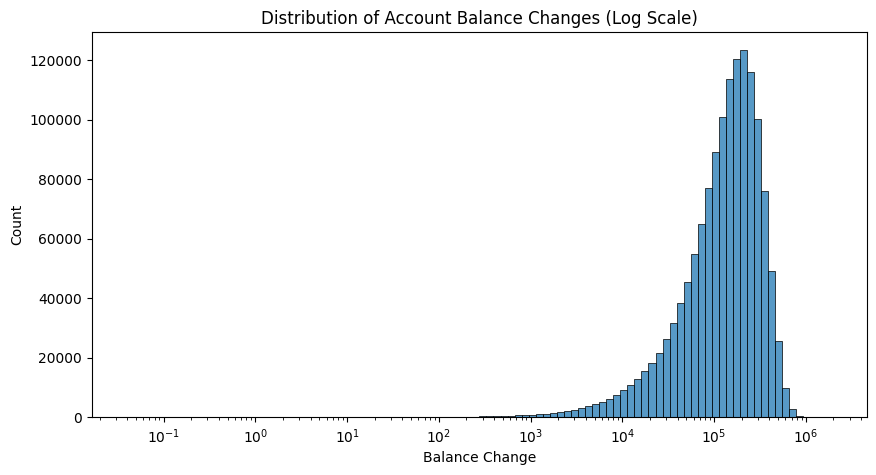

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(df["balance_change_orig"], bins=100, log_scale=True)
plt.title("Distribution of Account Balance Changes (Log Scale)")
plt.xlabel("Balance Change")
plt.show()

In [13]:
# Total amount per transaction type
report = df.groupby("type")["amount"].agg(["sum", "mean", "count"]).reset_index()
print(report)

# Save report
report.to_csv("financial_summary.csv", index=False)

       type           sum           mean    count
0   CASH_IN  2.363674e+11  168920.242004  1399284
1  CASH_OUT  3.944130e+11  176273.964346  2237500
2     DEBIT  2.271992e+08    5483.665314    41432
3   PAYMENT  2.809337e+10   13057.604660  2151495
4  TRANSFER  4.852920e+11  910647.009645   532909


In [17]:
# Get accounts that initiated fraudulent transactions
fraud_orig_accounts = df[df["isFraud"] == 1]["nameOrig"].value_counts().reset_index()
fraud_orig_accounts.columns = ["Account", "Fraud_Count"]

# Display the top fraudulent originating accounts
fraud_orig_accounts.head(10)


,Account,Fraud_Count
0,C1305486145,1
1,C755286039,1
2,C973279667,1
3,C258213312,1
4,C1640703547,1
5,C1127265876,1
6,C317779855,1
7,C1064034527,1
8,C1141104763,1
9,C1966863341,1


In [18]:
# Get accounts that received fraudulent transactions
fraud_dest_accounts = df[df["isFraud"] == 1]["nameDest"].value_counts().reset_index()
fraud_dest_accounts.columns = ["Account", "Fraud_Count"]

# Display the top fraudulent destination accounts
fraud_dest_accounts.head(10)

,Account,Fraud_Count
0,C1193568854,2
1,C104038589,2
2,C200064275,2
3,C1497532505,2
4,C1601170327,2
5,C1655359478,2
6,C2020337583,2
7,C1653587362,2
8,C1013511446,2
9,C2129197098,2


In [19]:
# Merge the two lists to see all accounts involved in fraud
fraudulent_accounts = pd.concat([fraud_orig_accounts, fraud_dest_accounts]).groupby("Account").sum().reset_index()

# Sort by the number of fraudulent transactions
fraudulent_accounts = fraudulent_accounts.sort_values(by="Fraud_Count", ascending=False)

# Display the top fraudulent accounts
fraudulent_accounts.head(10)


,Account,Fraud_Count
15546,C904300960,2
16075,C964377943,2
13396,C650699445,2
11173,C385133759,2
347,C104038589,2
5560,C1656842502,2
12197,C505532836,2
3001,C1366192319,2
8661,C2020337583,2
4177,C1497532505,2


In [20]:
fraudulent_accounts.to_csv("fraudulent_accounts.csv", index=False)
print("Fraudulent accounts data exported for Tableau.")

Fraudulent accounts data exported for Tableau.
